In [1]:
import numpy as np
import pandas as pd

from scipy.stats import binned_statistic_2d
from scipy.interpolate import griddata, interp2d
import pickle
import os


import astropy as ap
from astropy.io import fits
from astropy import table as t
from astropy.table import Table
from astropy import wcs
from astropy.cosmology import WMAP7

import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
from matplotlib import rcParams
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib import rc
from matplotlib import colors
from matplotlib.colors import LogNorm

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans"]
rcParams["text.usetex"] = True
rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"
rcParams['xtick.major.pad']='10'
rcParams['ytick.major.pad']='10'
rcParams['font.size'] = 22
rcParams['axes.labelsize'] = 22
rcParams['axes.labelweight'] = 'bold'
rcParams['axes.titlesize'] = 17
rcParams['xtick.labelsize'] = 17
rcParams['ytick.labelsize'] = 17
rcParams['legend.fontsize'] = 15
rcParams['figure.titlesize'] = 1

In [2]:
os.chdir("/Users/nitya/Work/data/Project2")

In [3]:
d1 = pd.read_csv('offset_mlratio_nearest_nonmodel_0.02.csv')
d2 = pd.read_csv('offset_mlratio_nearest_nonmodel_0.06.csv')
d3 = pd.read_csv('offset_mlratio_nearest_nonmodel_0.14.csv')

In [4]:
d1.head()

,Unnamed: 0,plate_ifu,z,hd_z,d4_z,hd_all,d4_all,offset_hd,offset_d4,mlz_z,mlz_all,offset_mlz
0,0,10001-12704,0.014122,2.756831,1.399400,3.090909,1.342825,0.334078,-0.056574,0.344417,0.028020,-0.316397
1,1,10213-9102,0.018773,4.271750,1.249259,1.470337,1.453276,-2.801413,0.204017,-0.030698,0.343930,0.374627
2,2,10214-6101,0.017492,4.622316,1.166559,4.413039,1.250179,-0.209277,0.083619,-0.022858,-0.031050,-0.008192
3,3,10214-6103,0.017672,2.833827,1.270369,4.025033,1.153019,1.191206,-0.117350,0.198610,0.327126,0.128515
4,4,10217-9102,0.015578,2.689720,1.019599,4.028885,1.070501,1.339166,0.050902,-0.032487,-0.280032,-0.247545


In [5]:
df = pd.read_csv('hd_d4000_mlratio_z.csv')
df.head()

,Unnamed: 0,specObjID,plateid_x,mjd_x,targettype_x,z_x,ra_x,dec_x,spectrotype_x,lick_hd_a,...,spectrotype_y,psfFlux_z,fiberFlux_z,modelMag_z,fiberMag_z,petroMag_z,psfMag_z,cModelMag_z,zband_lum,mlratio_z
0,1288098,571978357969807360,508,52366,GALAXY,0.065824,166.4783,2.094602,GALAXY,2.151605,...,GALAXY,28.06302,33.45266,16.86503,18.68839,16.92087,18.87891,16.92317,9.759862,0.189329
1,400208,1562851102729201664,1388,53119,GALAXY,0.111108,232.1581,32.259860,GALAXY,2.135609,...,GALAXY,68.12619,89.96645,15.89000,17.61473,15.95821,17.91659,15.79503,10.615238,0.347252
2,590268,2187701916006377472,1943,53386,GALAXY,0.061661,142.9699,32.348130,GALAXY,3.941239,...,GALAXY,42.61896,50.59392,17.25803,18.23952,17.33761,18.42566,17.28630,9.512923,0.006772
3,989578,487552899115673600,433,51873,GALAXY,0.106914,116.2391,37.233990,GALAXY,2.766207,...,GALAXY,26.55329,39.21035,16.65694,18.51611,16.68685,18.93886,16.56544,10.268623,-0.021323
4,169894,1130466224317163520,1004,52723,GALAXY,0.045666,167.0256,6.661255,GALAXY,2.404512,...,GALAXY,66.11886,75.75258,16.86960,17.80140,16.82482,17.94905,16.68491,9.409395,0.201458


In [6]:
df = df[df['lick_hd_a']>-10][df['lick_hd_a']<=12]
df = df[df['d4000_n']>0.5][df['lick_hd_a']<=12]
print(len(df))

/Users/nitya/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


735808


In [7]:
slope = (7.5+10)/(1.5-1.0)
print(slope)
intercept = -10-slope
print(intercept)

35.0
-45.0


/Users/nitya/miniconda3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/nitya/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


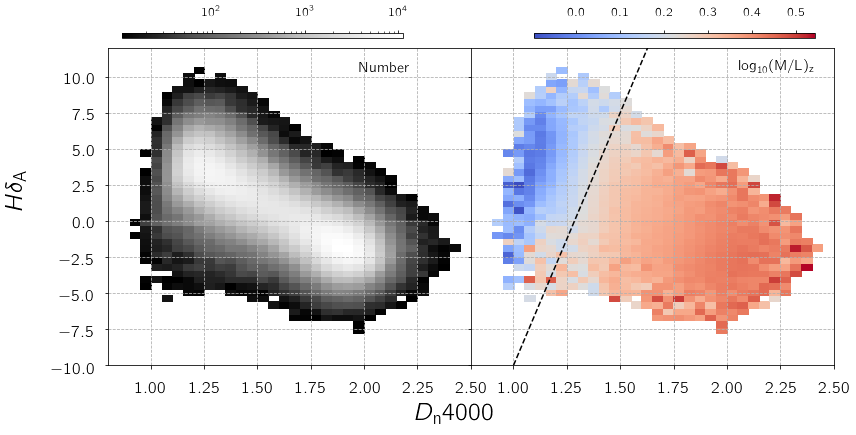

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (13,7))
t1 = binned_statistic_2d(df['d4000_n'], df['lick_hd_a'],
                         df['mlratio_z'],statistic = 'mean',bins=(50,50))

yedges1 = t1[1]
xedges1 = t1[2]
tcount = binned_statistic_2d(df['d4000_n'], df['lick_hd_a'],
                             df['mlratio_z'],statistic = 'count',bins=(yedges1,xedges1))

number = np.ma.array(tcount[0], mask = tcount[0] <= 10)
mass = np.ma.array(t1[0], mask = tcount[0] <= 10)

cs1 = ax1.pcolormesh(yedges1,xedges1,np.transpose(number), cmap = plt.cm.Greys_r, norm = LogNorm())
ax1.grid(linestyle = '--')
ax1.set_xlim(0.8,2.5)
ax1.set_ylim(-10,12)
#ax1.xaxis.set_ticklabels([1,1.25,1.5,2,2.25])

cs2 = ax2.pcolormesh(yedges1,xedges1,(np.transpose(mass)), cmap = plt.cm.coolwarm)
ax2.grid(linestyle = '--')
ax2.yaxis.set_ticklabels([])
ax2.set_xlim(0.8,2.5)
ax2.set_ylim(-10,12)
ax2.plot([1.0, 2.5],[-10.0,slope*2.5+intercept], linestyle = '--', color = 'k')

cbar_ax1 = fig.add_axes([0.14, 0.85, 0.3, 0.01])
cb1 = fig.colorbar(cs1,orientation = 'horizontal', cax=cbar_ax1)
cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.tick_params(labelsize=13)
cbar_ax2 = fig.add_axes([0.58, 0.85, 0.3, 0.01])
cb2 = fig.colorbar(cs2,orientation = 'horizontal', cax=cbar_ax2)
cb2.ax.xaxis.set_ticks_position('top')
cb2.ax.tick_params(labelsize=13)

fig.text(0.84, 0.79, r'${\rm log}_{10}(\rm M/L)_{z}$',
         ha='center', va='center', fontsize = 15)
fig.text(0.42, 0.79, 'Number',
         ha='center', va='center', fontsize = 15)
fig.text(0.495, 0.1, r'$D_{\rm n}4000$', 
         ha='center', va='center', fontsize = 25)
fig.text(0.03, 0.55, r'$H\delta_{\rm A}$', 
          rotation=90, ha='center', va='center', fontsize = 25)

plt.gcf().subplots_adjust(wspace=0, hspace = 0, top = 0.83, bottom = 0.2)
plt.savefig('/Users/Nitya/Desktop/hd_d4000_mlratio_coarser_binning.pdf')
plt.show()

In [9]:
df.columns

Index(['Unnamed: 0', 'specObjID', 'plateid_x', 'mjd_x', 'targettype_x', 'z_x',
       'ra_x', 'dec_x', 'spectrotype_x', 'lick_hd_a', 'lick_hd_a_err',
       'lick_hd_a_model', 'lick_hd_a_sub', 'lick_hd_a_sub_err', 'd4000_n',
       'd4000_n_err', 'd4000_n_model', 'd4000_n_sub', 'd4000_n_sub_err',
       'lgm_tot_p50', 'sfr_tot_p50', 'plateid_y', 'mjd_y', 'targettype_y',
       'z_y', 'ra_y', 'dec_y', 'spectrotype_y', 'psfFlux_z', 'fiberFlux_z',
       'modelMag_z', 'fiberMag_z', 'petroMag_z', 'psfMag_z', 'cModelMag_z',
       'zband_lum', 'mlratio_z'],
      dtype='object')

In [10]:
newdf1 = df.query('lick_hd_a - @slope*d4000_n < @intercept')
#plt.scatter(newdf1['d4000_n'], newdf1['lick_hd_a'], s = 0.01)
#plt.show()
newdf2 = df.query('lick_hd_a - @slope*d4000_n > @intercept')
#plt.scatter(newdf2['d4000_n'], newdf2['lick_hd_a'], s = 0.01)
#plt.show()
mean_mlratio_lesser = np.mean(newdf1['mlratio_z'].values)
mean_mlratio_greater = np.mean(newdf2['mlratio_z'].values)

print(mean_mlratio_lesser, mean_mlratio_greater)

0.36439355021371866 0.13373581768744314


In [11]:
d1.columns

Index(['Unnamed: 0', 'plate_ifu', 'z', 'hd_z', 'd4_z', 'hd_all', 'd4_all',
       'offset_hd', 'offset_d4', 'mlz_z', 'mlz_all', 'offset_mlz'],
      dtype='object')

In [12]:
d1.head()

,Unnamed: 0,plate_ifu,z,hd_z,d4_z,hd_all,d4_all,offset_hd,offset_d4,mlz_z,mlz_all,offset_mlz
0,0,10001-12704,0.014122,2.756831,1.399400,3.090909,1.342825,0.334078,-0.056574,0.344417,0.028020,-0.316397
1,1,10213-9102,0.018773,4.271750,1.249259,1.470337,1.453276,-2.801413,0.204017,-0.030698,0.343930,0.374627
2,2,10214-6101,0.017492,4.622316,1.166559,4.413039,1.250179,-0.209277,0.083619,-0.022858,-0.031050,-0.008192
3,3,10214-6103,0.017672,2.833827,1.270369,4.025033,1.153019,1.191206,-0.117350,0.198610,0.327126,0.128515
4,4,10217-9102,0.015578,2.689720,1.019599,4.028885,1.070501,1.339166,0.050902,-0.032487,-0.280032,-0.247545


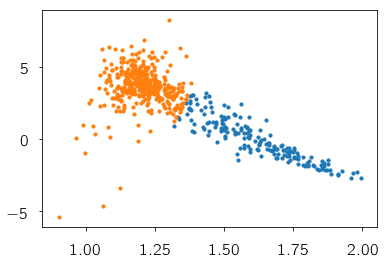

0.34499662160434397 0.09410462897609957
-0.0316397516029416 -0.005860542994972394


In [13]:
newdf1 = d1.query('hd_z - @slope*d4_z < @intercept')

newdf2 = d1.query('hd_z - @slope*d4_z > @intercept')


plt.scatter(newdf1['d4_z'], newdf1['hd_z'], s = 10)
plt.scatter(newdf2['d4_z'], newdf2['hd_z'], s = 10)
plt.show()
mean_mlratio_lesser_1 = np.mean(newdf1['mlz_z'].values)
mean_mlratio_greater_1 = np.mean(newdf2['mlz_z'].values)
mean_offset_lesser_1 = np.mean(newdf1['offset_mlz'].values)
mean_offset_greater_1 = np.mean(newdf2['offset_mlz'].values)

print(mean_mlratio_lesser_1, mean_mlratio_greater_1)
print(mean_offset_lesser_1, mean_offset_greater_1)

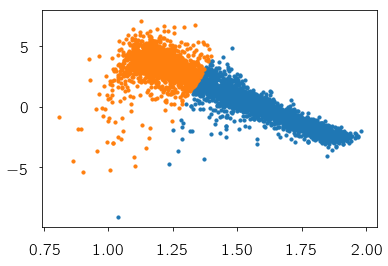

0.3438216332705667 0.09527779790707513
-0.030836826531198003 -0.02295000837506006


In [14]:
newdf1 = d2.query('hd_z - @slope*d4_z < @intercept')

newdf2 = d2.query('hd_z - @slope*d4_z > @intercept')


plt.scatter(newdf1['d4_z'], newdf1['hd_z'], s = 10)
plt.scatter(newdf2['d4_z'], newdf2['hd_z'], s = 10)
plt.show()
mean_mlratio_lesser_2 = np.mean(newdf1['mlz_z'].values)
mean_mlratio_greater_2 = np.mean(newdf2['mlz_z'].values)
mean_offset_lesser_2 = np.mean(newdf1['offset_mlz'].values)
mean_offset_greater_2 = np.mean(newdf2['offset_mlz'].values)

print(mean_mlratio_lesser_2, mean_mlratio_greater_2)
print(mean_offset_lesser_2, mean_offset_greater_2)

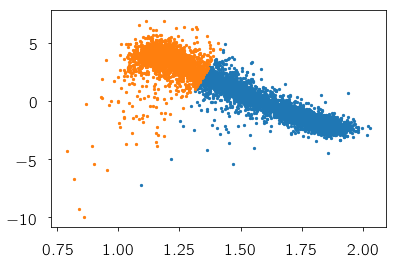

0.3515875469022856 0.08656038064332172
-0.021156091049345595 -0.009868642041769064


In [15]:
newdf1 = d3.query('hd_z - @slope*d4_z < @intercept')

newdf2 = d3.query('hd_z - @slope*d4_z > @intercept')


plt.scatter(newdf1['d4_z'], newdf1['hd_z'], s = 5)
plt.scatter(newdf2['d4_z'], newdf2['hd_z'], s = 5)
plt.show()
mean_mlratio_lesser_3 = np.mean(newdf1['mlz_z'].values)
mean_mlratio_greater_3 = np.mean(newdf2['mlz_z'].values)
mean_offset_lesser_3 = np.mean(newdf1['offset_mlz'].values)
mean_offset_greater_3 = np.mean(newdf2['offset_mlz'].values)

print(mean_mlratio_lesser_3, mean_mlratio_greater_3)
print(mean_offset_lesser_3, mean_offset_greater_3)

In [105]:
cell_text = [[mean_mlratio_lesser_1, mean_mlratio_lesser_2, mean_mlratio_lesser_3],
            [mean_offset_lesser_1,mean_offset_lesser_2,mean_offset_lesser_3],
             [mean_mlratio_greater_1, mean_mlratio_greater_2, mean_mlratio_greater_3],
             [mean_offset_greater_1,mean_offset_greater_2,mean_offset_greater_3]]
rows = ['Mean M/L Ratio (below line)','Mean Offset (below line)', 
        'Mean M/L Ratio (above line)','Mean Offset (above line)']
columns = [r'$z = 0.02$', r'$z = 0.06$', r'$z = 0.14$']

In [106]:
cell_text = np.around(cell_text, decimals = 4)

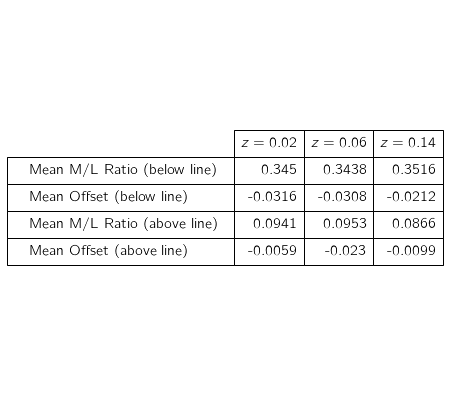

In [107]:


# Adjust layout to make room for the table:
# plt.subplots_adjust(left=0.2, bottom=0.2)

# plt.ylabel("Loss in ${0}'s".format(value_increment))
# plt.yticks(values * value_increment, ['%d' % val for val in values])
# plt.xticks([])
# plt.subplots_adjust(left=0.2, top=0.8)
# plt.title('Loss by Disaster')

# plt.show()


fig, axs = plt.subplots(figsize = (8,3))

# Hide axes
axs.axis("off") 
#axs.axis('tight')
the_table = axs.table(cellText=cell_text,
                      rowLabels=rows,
                      colLabels=columns,
                      loc = 'center')
the_table.set_fontsize(22)
#fig.set_size_inches(w=3, h=2)
fig.tight_layout()
plt.subplots_adjust(left=0.6, top= 1.3, bottom = -0.4)
plt.savefig('/Users/Nitya/Desktop/table.pdf')
plt.show()

In [73]:
np.around(1.2356324, decimals = 3)

1.236